# Bài tập về nhà 3: Softmax Regression

Trong bài tập này, các bạn sẽ sử dụng kiến thức đã học về softmax regression để giải quyết bài toán phân loại nhiều lớp, cụ thể là 10 lớp (áo, quần, giày dép, ....) từ bộ dữ liệu [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist).

## Giới thiệu
Để hoàn tất bài tập này, các bạn cần nắm rõ những kiến thức sau:
* Softmax Regression
* Cách lấy đạo hàm cho các tham số trong mô hình trên.
* Giải thuật gradient descent.

Bạn có thể tham khảo lại bài giảng để nắm vững các nội dung này. Ngoài ra, các bạn có thể đặt câu hỏi cho đội ngũ giảng viên nếu có thắc mắc.

Bạn cần giải quyết bài tập này bằng cả **numpy** và **Tensorflow**.

*Lưu ý: để tiện cho việc phân biệt giữa lớp python và lớp trong bài toán phân loại, người viết quy ước rằng khi viết **class** nghĩa là đang nói về python class, khi viết **lớp** nghĩa là đang nói đến lớp của dữ liệu cần phân loại.

## Hướng dẫn nộp bài
Ở mỗi bài tập, các bạn sẽ được yêu cầu điền phần còn thiếu vào trong hàm, các cell để thực hiện phần bài làm sẽ có dòng đầu tiên như sau:
```python
# GRADED FUNCTION: <tên hàm>
...
```
Trong cell đó, các bạn sẽ code phần đáp án của mình giữa 2 phần:
```python
### START CODE HERE ###
<phần bài làm>
### END CODE HERE ###
```
Sau khi thực hiện xong bạn từ terminal, bạn chạy file `submit.py` để nộp bài tập.
```
python submit.py -filepath <PATH_ĐẾN_FILE_BÀI_LÀM_CỦA_BẠN>
```
Mặc định `-filepath` là `3_Softmax_Regression.ipynb`. Nếu bạn không thay đổi tên hoặc vị trí file bài tập. Bạn có thể đơn giản gọi dòng lệnh sau để nộp bài:
```
python submit.py
```
Sau khi chạy dòng lệnh trên, vui lòng điền `username` và `password`, bạn sẽ nhận được kết quả trả về cho bài làm của bạn.

## IMPORT CÁC THƯ VIỆN CẦN THIẾT
Nếu chạy trên máy tính cá nhân, trước hết bạn cần install các thư viện cần thiết bằng cách chạy dòng lệnh sau trong terminal:
```
pip install -r requirements.txt
```
Nếu bạn chạy trên nền tảng Google Colab, bạn có thể bổ qua bước trên.

In [ ]:
# IMPORT
import numpy as np
import gzip
import matplotlib.pyplot as plt
import tensorflow as tf

## Tải dữ liệu
Các bạn chạy cell bên dưới để tải bộ dữ liệu cũng như các hàm dùng để test cách cài đặt của các bạn:

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1umcIzISPX2FhMT3OBg-Io7LninG7Hste', dest_path='./assignment3.zip', unzip=True)
!rm assignment3.zip

Unzipping...Done.


Dữ liệu tải xuống của bạn bao gồm:

* Folder `fashion-mnist`: chứa 4 zip files dữ liệu.
* File softmax_unittest.npy: được dùng để kiểm tra một số hàm mà bạn cài đặt.

In [ ]:
!ls assignment3

fashion-mnist  softmax_unittest.npy


## Các hàm bổ trợ dùng để đọc dữ liệu
Nhóm TA sẽ giúp bạn định nghĩa các hàm bổ trợ trong việc đọc dữ liệu, các bạn không cần chỉnh sửa những hàm này.

In [ ]:
"""
These functions help you read data from data files.
Author: Kien Huynh
"""

def read_mnist_gz(data_path, offset):
    with gzip.open(data_path, 'rb') as f:
        dataset = np.frombuffer(f.read(), dtype=np.uint8, offset=offset)

    return dataset


def get_mnist_data(sampling_step=20):
    print('Reading fashion MNIST data...')
    train_x = read_mnist_gz('./assignment3/fashion-mnist/train-images-idx3-ubyte.gz', 16)
    train_y = read_mnist_gz('./assignment3/fashion-mnist/train-labels-idx1-ubyte.gz', 8)
    test_x = read_mnist_gz('./assignment3/fashion-mnist/t10k-images-idx3-ubyte.gz', 16)
    test_y = read_mnist_gz('./assignment3/fashion-mnist/t10k-labels-idx1-ubyte.gz', 8)
    num_train = len(train_y)
    num_test = len(test_y)

    train_x = train_x.reshape((num_train, 28*28))
    test_x = test_x.reshape((num_test, 28*28))

    val_x = train_x[50000:,:]
    val_y = train_y[50000:]
    train_x = train_x[:50000,:]
    train_y = train_y[:50000]

    train_x = train_x[0::sampling_step,:]
    train_y = train_y[0::sampling_step]
    val_x = val_x[0::sampling_step,:]
    val_y = val_y[0::sampling_step]
    test_x = test_x[0::sampling_step,:]
    test_y = test_y[0::sampling_step]
    return train_x.astype(np.float32), train_y, val_x.astype(np.float32), val_y, test_x.astype(np.float32), test_y

def get_side(img, side_type, n = 5):
    h, w = img.shape
    if side_type == "horizontal":
        return np.ones((h,n))
    return np.ones((n,w))

def show_gallery(ims,n=5, shuffle=True):
    images = []
    vertical_images = []
    if shuffle:
        np.random.shuffle(ims)
    vertical_images = []
    for i in range(n*n):
        img = ims[i].reshape(28,28)
        hside = get_side(img,side_type="horizontal")
        images.append(img)
        images.append(hside)
        
        if (i+1) % n == 0:
            himage=np.hstack((images))
            vside = get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images = []
        
    gallery = np.vstack((vertical_images))
    plt.figure(figsize=(20,20))
    plt.axis("off")
    plt.imshow(gallery.astype(np.uint8), cmap="gray")
    plt.show()

def add_one(x):
    """add_one
    This function add ones as an additional feature for x.

    :param x: input data
    """
    x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
    return x

def create_one_hot(labels, num_k=10):
    """create_one_hot
    This function creates a one-hot (one-of-k) matrix based on the given labels

    :param labels: list of labels, each label is one of 0, 1, 2,... , num_k - 1
    :param num_k: number of classes we want to classify
    """
    eye_mat = np.eye(num_k)
    eye_mat = eye_mat[labels, :].astype(np.float32)
    return eye_mat

## Dữ liệu fashion MNIST

Ta có thể đọc tập dữ liệu này bằng hàm `get_mnist_data()`:

In [ ]:
train_x, train_y, val_x, val_y, test_x, test_y = get_mnist_data()

Reading fashion MNIST data...


Tập dữ liệu này gồm các ảnh xám kích thước $28 \times 28$. Có tất cả 50000 ảnh train, 10000 ảnh validation và 10000 ảnh test. Mỗi ảnh thuộc một trong 10 loại quần, áo, giày, túi xách, v.v. Tuy nhiên trong bài tập này ta chỉ lấy 2500 ảnh train, 500 ảnh validation và 500 ảnh test.

In [ ]:
print("train_x: " ,train_x.shape)
print("train_y: ", train_y.shape)
print("val_x:   ", val_x.shape)
print("val_y:   ", val_y.shape)
print("test_x:  ", test_x.shape)
print("test_y:  ", test_y.shape)

train_x:  (2500, 784)
train_y:  (2500,)
val_x:    (500, 784)
val_y:    (500,)
test_x:   (500, 784)
test_y:   (500,)


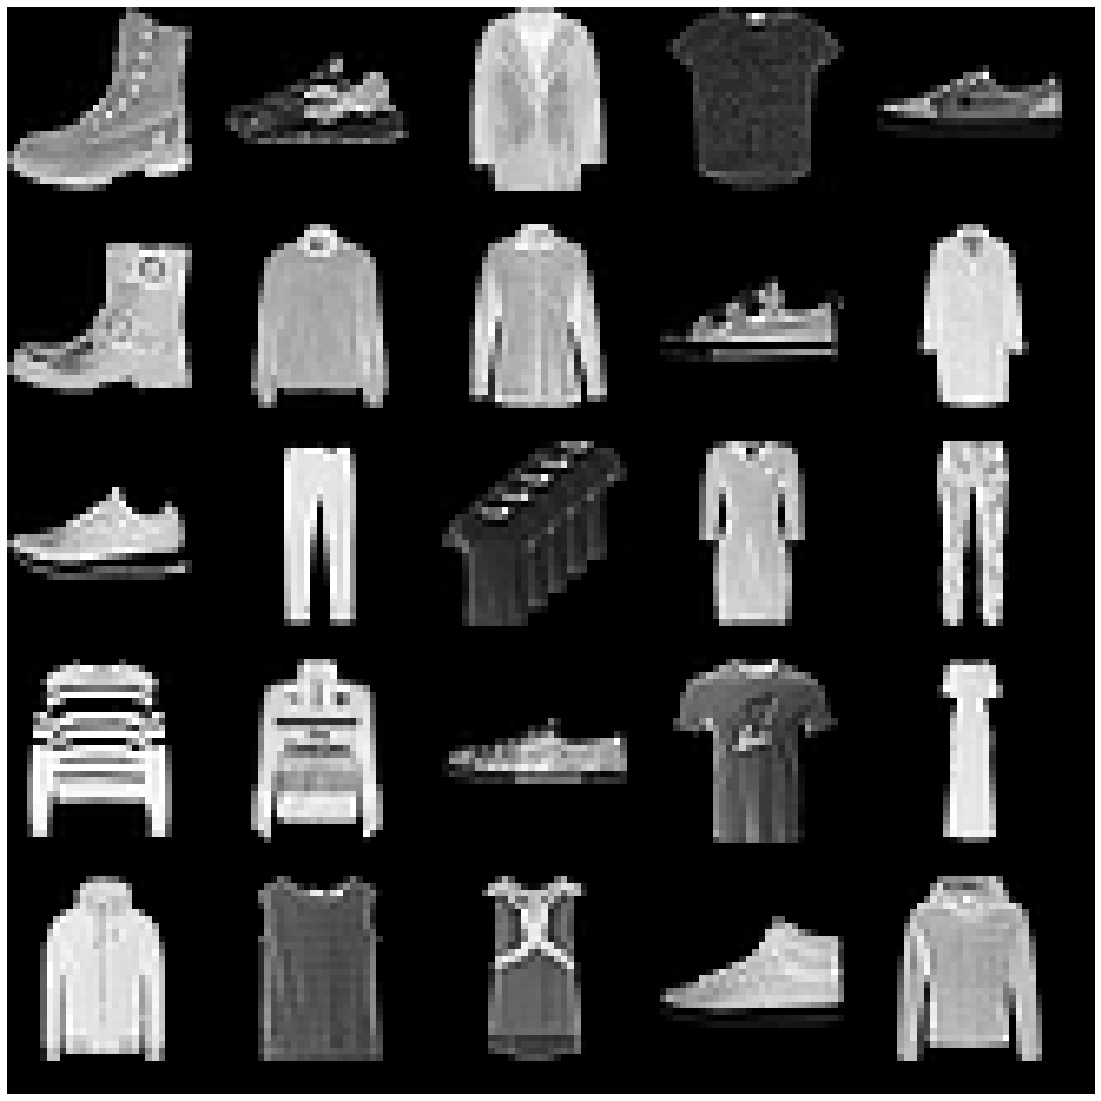

In [ ]:
show_gallery(train_x, n=5, shuffle=True)

Giá trị của `train_y` và `test_y` có thể là 0, 1, ..., 9 thay vì là 0 và 1 như bài 2 (Logistic Regression). Ngoài ra, dữ liệu ảnh khi được đọc lên sẽ có dạng tensor 2D (3500x784).

## Chuẩn hóa dữ liệu
Trong bước này, ta sẽ chuẩn hóa dữ liệu `train_x`, `val_x` và `test_x` theo cách xem các pixel khác nhau trong ảnh là cùng 1 loại đặc trưng (như đã đề cập trong bài tập Logistic Regression).

\begin{equation}
\overline{x} = \frac{1}{mRC}\sum_{i=0}^{m-1}{\sum_{r=0}^{R-1}{\sum_{c=0}^{C-1}{x_{rc}^{(i)}}}} \tag{3}
\end{equation}

\begin{equation}
\sigma=\sqrt{\frac{1}{mRC}\sum_{i=0}^{m-1}{\sum_{r=0}^{R-1}{\sum_{c=0}^{C-1}{(x_{rc}^{(i)}-\overline{x})^2}}}} \tag{4}
\end{equation}

Sau khi có được mean và std trên toàn bộ data huấn luyện, ta chuẩn hóa các mẫu trong tập huấn luyện theo cách sau:

\begin{equation}
x^{(i)} = \frac{x^{(i)}-\overline{x}}{\sigma} \tag{5}
\end{equation} 

Tuy nhiên, do tập dữ liệu MNIST khi load đã được đặt dưới dạng tensor 2D, nên trong công thức tính tổng chỉ còn $m$ và $R=784$.

### TODO 1: normalize (10)

In [ ]:
# GRADED FUNCTION: normalize
def normalize(train_x, val_x, test_x):
    """TODO 1: normalize
    This function computes the mean and standard deviation of all pixels and performs data scaling on train_x, val_x and test_x using these computed values.
    Note that in this classification problem, the shape of the data is (num_samples, image_width * image_height).

    :param train_x: train images, shape=(num_train, image_height * image_width)
    :param val_x: validation images, shape=(num_val, image_height * image_width)
    :param test_x: test images, shape=(num_test, image_height * image_width)
    """
    # The shape of train_mean and train_std should be (1, 1)
    ### START CODE HERE ### (≈5 lines)
    train_mean = np.mean(train_x, axis=(0,1), dtype=np.float64, keepdims=True)
    train_std = np.std(train_x, axis=(0,1), dtype=np.float64, keepdims=True)
    train_x = (train_x-train_mean)/train_std
    val_x = (val_x-train_mean)/train_std
    test_x = (test_x-train_mean)/train_std
    ### END CODE HERE ###
    return train_x, val_x, test_x

In [ ]:
### SANITY CHECK
train_x = np.arange(2*4).reshape(2, 4)
x, y, z = normalize(train_x, train_x, train_x)
assert np.sum((x, y, z)) == 0, "Wrong"

## Tiền xử lý vector label thành dạng one-hot

Các biến `train_y`, `val_y`, `test_y` lúc này là một vector chứa các giá trị 0, 1, ..., 9; nhưng để tính hàm lỗi của softmax regression, ta nên chuyển chúng về dạng ma trận one-hot (one-of-k). Giả sử ta có vector label có 6 phần tử, mỗi phần tử nằm trong khoảng từ 0 đến 4:

\begin{equation}
	y = [3,4,0,0,2,1]^T \tag{17}
\end{equation}

Ta sẽ có biến đổi one-hot tương ứng của nó là:
\begin{equation}
y = \begin{bmatrix}
	0 & 0 & 0 & \color{red}1 & 0\\
	0 & 0 & 0 & 0 & \color{red}1\\
	\color{red}1 & 0 & 0 & 0 & 0\\
	\color{red}1 & 0 & 0 & 0 & 0\\
	0 & 0 & \color{red}1 & 0 & 0\\
	0 & \color{red}1 & 0 & 0 & 0
\end{bmatrix} \tag{18}
\end{equation}

Label thứ nhất có giá trị là 3, vì vậy nên trong hàng thứ nhất ở ma trận trên cột 3 có giá trị 1, tất cả các cột khác trong hàng này là 0. Tương tự cho hàng thứ 2, label là 4, nên cột 4 trong hàng 2 có giá trị là 1.


Để việc biến đổi giá trị của mảng sang dạng one-hot được nhanh chóng, ta nên sử dụng index array hay index vector trên ma trận đơn vị. Tham khảo thêm ở đây: [Numpy basic indexing - Index arrays](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.indexing.html#index-arrays).

## Tính các giá trị phân loại

Để tính các giá trị phân loại trong bài này, ta hiện thực các công thức sau trong hàm `feed_forward` và `softmax`:

\begin{equation}
z = xw \space, \quad x \in R^{m\times D}, w \in R^{D \times K} \tag{19}
\end{equation}

Trong đó, $m$ là số lượng mẫu dữ liệu, $D$ là số lượng đặc trưng của dữ liệu đầu vào (785 sau khi thêm 1 vào cuối), $K$ là số lượng nhãn trong bài toán ta đang làm (10).

\begin{equation}
z_{max} = [max(z^{(0)}), max(z^{(1)}),.., max(z^{(m-1)})]^T  \tag{20}
\end{equation}

Tại đây, $z_{max}$ là một vector cột (kích thước $m \times 1$).

\begin{equation}
z' = e^{z - z_{max}} \tag{21}
\end{equation}

Trong biểu thức trên, ta sẽ dùng cột thứ nhất của $z$ trừ cho $z_{max}$, cột thứ 2 của $z$ trừ cho $z_{max}$, v.v. Sau đó, ta tính lũy thừa cho từng phần tử trên hiệu đã tính. Kết quả tại bước này là một ma trận $z'$ có kích thước $m \times K$.

Kế tiếp, ta cần tính tổng sau:

\begin{equation}
s = \sum^{K-1}_{k=0}z'^{(i)}_{k} ,\quad 0\le i \le m-1\tag{22}
\end{equation}

Như vậy, $s$ sẽ là vector chứa tổng từng hàng của ma trận $z'$. $s$ có kích thước $m \times 1$. Sau cùng, ta có thể tính softmax bằng cách lấy mỗi phần tử trong $z'$ chia cho tổng hàng tương ứng:

\begin{equation}
\hat{y}^{(i)}_{k} = \frac{z'^{(i)}_{k}}{s^{(i)}}, \quad 0\le i \le m-1, 0\le k \le K-1 \tag{23}
\end{equation}

Sau khi tổng hợp lại toàn bộ các phần tử $i, k$ của $\hat{y}$, ta sẽ có ma trận có kích thước $m \times K$. Trong ma trận này, mỗi hàng thứ $i$ biểu diễn vector xác suất lớp của mẫu ảnh thứ $i$. Vì vậy, tổng của mỗi hàng luôn bằng 1.

## Class SoftmaxClassifier với numpy

Tương tự như class `LogisticClassifier` đã cài đặt ở bài trước, class SoftmaxClassifier cần được khởi tạo trọng số `w` và có thể sử dụng lại hàm `update_weight` của class `LogisticClassifier`.

In [ ]:
# GRADED FUNCTION
class SoftmaxClassifier(object):
    def __init__(self, w_shape):
        """__init__
        
        :param w_shape: create w with shape w_shape using normal distribution
        """
        self.w = np.random.normal(0, np.sqrt(2./np.sum(w_shape)), w_shape)


    def softmax(self, x):
        """TODO 2: softmax

        :param x: input
        """
        result = None
        ### START CODE HERE ### (≈4 lines)
        max_x = np.max(x, axis=1, keepdims=True)
        x -= max_x
        x_exp = np.exp(x)
        result = x_exp / np.sum(x_exp, axis=1, keepdims=True)
        
        ### END CODE HERE ###
        return result


    def feed_forward(self, x):
        """TODO 3: feed_forward
        This function computes the output of your softmax regression model
        
        :param x: input
        """
        result = None
        ### START CODE HERE ### (≈2 lines)
        x_out = np.dot(x, self.w)
        result = self.softmax(x_out)
        ### END CODE HERE ###
        return result


    def compute_loss(self, y, y_hat):
        """TODO 4: compute_loss
        Compute the loss using y (label) and y_hat (predicted class)

        :param y:  the label, the actual class of the sample data
        :param y_hat: the classifying probabilities of all sample data
        """
        loss = 0
        ### START CODE HERE ### (≈3 lines)
        loss = -np.log(y_hat) 
        loss = np.sum(loss*y, axis=1)
        loss = np.mean(loss)
        ### END CODE HERE ###
        return loss


    def get_grad(self, x, y, y_hat):
        """TODO 5: get_grad
        Compute and return the gradient of w

        :param loss: computed loss between y_hat and y in the train dataset
        :param y_hat: predicted y
        """ 
        w_grad = None
        ### START CODE HERE ### (≈2 lines)
        num_x = x.shape[0]
        w_grad = np.dot(x.T, -(y - y_hat))/num_x
        ### END CODE HERE ###
        return w_grad
   

    def update_weight(self, grad, learning_rate):
        """update_weight
        Update w using the computed gradient.

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        """
        self.w = self.w - learning_rate*grad 
        return self.w


    def update_weight_momentum(self, grad, learning_rate, momentum, momentum_rate):
        """update_weight using momentum
        BONUS:[YC1.8]
        Update w using the algorithm with momentum

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        :param momentum: the array storing momentum for training w, should have the same shape as that of w
        :param momentum_rate: float, how much momentum to reuse after each loop (denoted as gamma in the following section)
        """
        momentum *= momentum_rate
        momentum += learning_rate*grad
        self.w = self.w - momentum
        return self.w
    
    def numerical_check(self, x, y, grad):
        i = 3
        j = 0
        eps = 0.000005
        w_test0 = np.copy(self.w)
        w_test1 = np.copy(self.w)
        w_test0[i,j] = w_test0[i,j] - eps
        w_test1[i,j] = w_test1[i,j] + eps

        y_hat0 = np.dot(x, w_test0)
        y_hat0 = self.softmax(y_hat0)
        loss0 = self.compute_loss(y, y_hat0) 

        y_hat1 = np.dot(x, w_test1)
        y_hat1 = self.softmax(y_hat1)
        loss1 = self.compute_loss(y, y_hat1) 

        numerical_grad = (loss1 - loss0)/(2*eps)
        print(numerical_grad)
        print(grad[i,j])

In [ ]:
### SANITY CHECK
eps = 0.001        
classifier = SoftmaxClassifier((3,1))
classifier.w = np.arange(3*1).reshape(3,1)
x = np.ones(2*3).reshape(2,3)/2
y = 0
y_hat = classifier.feed_forward(x)
assert sum(y_hat)==2, "Wrong"
loss = classifier.compute_loss(y, y_hat)
assert loss==0, "Wrong"
grad = classifier.get_grad(x, y, y_hat)
assert sum(grad)==1.5, "Wrong"
updateweight = classifier.update_weight(grad, 0.1)
assert sum(updateweight) - 2.849 < eps, "Wrong"
updatemomen = classifier.update_weight_momentum(grad, 0.1, 0.1, 0.1)
assert sum(updatemomen) - 2.67 < eps, "Wrong"

### TODO 2: feed_forward (10)
Các bạn hoàn thành hàm `feed_forward` ở phần class SoftmaxClassifier.

### TODO 3: softmax (10)
Các bạn hoàn thành hàm `softmax` ở phần class SoftmaxClassifier.

### Tính độ lỗi
Công thức tính độ lỗi category như sau:

\begin{equation}
J(w) = -\frac{1}{m}\sum_{i=0}^{m-1}\sum_{k=0}^{K-1} y^{(i)}_k \log\hat{y}^{(i)}_k \tag{24}
\end{equation}

Trong đó:
- $y^{(i)}_k$ là phần tử hàng $i$ cột $k$ trong ma trận nhãn one-hot $y$ (đã đề cập trong phần trước).
- $\hat{y}^{(i)} \in (0, 1)$ là hàng $i$ cột $k$ trong ma trận $\hat{y}$.

#### TODO 4: compute_loss (10)
Các bạn hoàn thành hàm `compute_loss` ở phần class SoftmaxClassifier.

## Tính đạo hàm
Công thức tính đạo hàm theo từng tham số $w_{jk}$ được biểu diễn như sau:

\begin{equation}
\frac{\partial  J(w_{jk})}{\partial w_{jk}} = \frac{1}{m}\sum_{i=0}^{m-1} x^{(i)}_j (\hat{y}^{(i)}_k - y^{(i)}_k) \tag{25}
\end{equation}

Với $0 \le j \le D-1$. Viết lại dưới dạng ma trận ta có được:

\begin{equation}
\frac{\partial  J(w)}{\partial w} = \frac{1}{m}x^T(\hat{y} - y) \tag{26}
\end{equation}

### TODO 5: get_grad (10)
Các bạn hoàn thành hàm `get_grad` ở phần class SoftmaxClassifier.

## Đề xuất điều kiện dùng vòng lặp huấn luyện

Trong bài này, ngoài việc sử dụng `train_x`, `train_y` để huấn luyện, file mẫu còn cung cấp cho các bạn các biến `val_x`, `val_y` để thực hiện việc validation. Toàn bộ các giá trị lỗi validation được lưu trong biến `all_val_loss`. Trong phần này, nhiệm vụ của các bạn là đề xuất ra điều kiện dừng khác (ngoài việc `e` đạt `num_epoch`) trong quá trình huấn luyện. Dựa vào độ lỗi validation, bạn có thể sử dụng các tiêu chí mình tự đề ra để tránh việc quá trình huấn luyện bị overfitting.

### TODO 6: is_stop_training (20)
Các bạn hoàn thành hàm `is_stop_training` nhận vào mảng `all_val_loss` và trả về giá trị boolean True hoặc False quyết định có dừng việc huấn luyện không. Nếu loss trên tập validation tăng hơn n (patience) lần liên tiếp thì trả về True, ngược lại thì False.

In [ ]:
# GRADED FUNCTION
def is_stop_training(all_val_loss, patience=5):
    """TODO 6:  is_stop_training
    Check whether training need to be stopped

    :param all_val_loss: list of all validation loss values during training
    """
    is_stopped = False
    ### START CODE HERE ###
    num_val_increase = 0
    if (len(all_val_loss)<2):
        return False
    for i in range(len(all_val_loss)-1,0,-1):
        if all_val_loss[i] > all_val_loss[i-1]:
            num_val_increase += 1
        if num_val_increase >= 5:
            return True
    ### END CODE HERE ###
    return is_stopped

In [ ]:
### SANITY CHECK
assert is_stop_training([1, 2, 3, 4, 5, 6]) == True, "Wrong"
assert is_stop_training([1, 2, 3]) == False, "Wrong"

## Đánh giá mô hình trên dữ liệu test

Để đánh giá mô hình phân loại nhiều lớp, ta cần sử dụng một khái niệm gọi là confusion matrix. Giả sử ta có bài toán phân loại 3 lớp, thì confusion matrix có dạng sau:

<table>
    <th>
        <td>Lớp 1</td>
        <td>Lớp 2</td>
        <td>Lớp 3</td>
    </th>
    <tr>
        <td>Lớp 1</td>
        <td>$N_{11}$</td>
        <td>$N_{12}$</td>
        <td>$N_{13}$</td>
    </tr>
    <tr>
        <td>Lớp 2</td>
        <td>$N_{21}$</td>
        <td>$N_{22}$</td>
        <td>$N_{23}$</td>
    </tr>
    <tr>
        <td>Lớp 3</td>
        <td>$N_{31}$</td>
        <td>$N_{32}$</td>
        <td>$N_{33}$</td>
    </tr>
</table>

Trong đó, $N_{kl}$ là tổng số mẫu thực chất thuộc lớp $k$ và bộ phân loại phân loại thành lớp $l$ chia cho tổng số mẫu trong lớp k. Bộ phân loại càng tốt thì các ô trên đường chéo chính sẽ càng cao hơn so với các ô xung quanh. Khi tiến hành kiểm thử, người ra đề đã tính được confusion matrix như sau:

<table>
    <tr>
        <td>0.93</td>
        <td>0</td>
        <td>0</td>
        <td>0.02</td>
        <td>0</td>
        <td>0</td>
        <td>0.05</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0.95</td>
        <td>0</td>
        <td>0.05</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0.02</td>
        <td>0.02</td>
        <td>0.59</td>
        <td>0.02</td>
        <td>0.22</td>
        <td>0</td>
        <td>0.13</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0.05</td>
        <td>0.03</td>
        <td>0.03</td>
        <td>0.82</td>
        <td>0.05</td>
        <td>0</td>
        <td>0.03</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0.07</td>
        <td>0.05</td>
        <td>0.77</td>
        <td>0</td>
        <td>0.12</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0.89</td>
        <td>0</td>
        <td>0.09</td>
        <td>0.02</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0.21</td>
        <td>0</td>
        <td>0.08</td>
        <td>0.02</td>
        <td>0.17</td>
        <td>0</td>
        <td>0.51</td>
        <td>0</td>
        <td>0.02</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0.04</td>
        <td>0</td>
        <td>0.86</td>
        <td>0</td>
        <td>0.1</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0.02</td>
        <td>0</td>
        <td>0.04</td>
        <td>0</td>
        <td>0.02</td>
        <td>0.93</td>
        <td>0</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0.02</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0.98</td>
    </tr>
</table>

Bạn cần đạt được kết quả tương tự hoặc tốt hơn sau khi hoàn tất bài tập 2 này.

### TODO 7: softmax_test (20)

In [ ]:
# GRADED FUNCTION
def softmax_test(y_hat, test_y):
    """TODO 7: test
    Compute the confusion matrix based on labels and predicted values 

    :param classifier: the trained classifier
    :param y_hat: predicted probabilites, output of classifier.feed_forward
    :param test_y: test labels
    """

    y_hat = np.argmax(y_hat, axis=1)
    test_y = np.argmax(test_y, axis=1)
    confusion_mat = np.zeros((10,10))
    ### START CODE HERE ###
    for i in range(10):
        class_i_idx = test_y == i
        num_class_i = np.sum(class_i_idx)
        y_hat_i = y_hat[class_i_idx]
        for j in range(10):
            confusion_mat[i,j] = 1.0*np.sum(y_hat_i == j)/num_class_i
    
    ### END CODE HERE ###
    return confusion_mat

In [ ]:
y_hat = np.eye(20, 10)
test_y = y_hat > 0.5
assert np.trace(softmax_test(y_hat, test_y)) == 10, "Wrong"

## Vòng lặp huấn luyện

In [ ]:
def plot_softmax_loss(train_loss, val_loss):
    plt.figure(1)
    plt.clf()
    plt.plot(train_loss, color='b')
    plt.plot(val_loss, color='g')


def draw_weight(w):
    label_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    plt.figure(2, figsize=(8, 6))
    plt.clf()
    w = w[0:(28*28),:].reshape(28, 28, 10)
    for i in range(10):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(w[:,:,i], interpolation='nearest')
        plt.axis('off')
        ax.set_title(label_names[i])

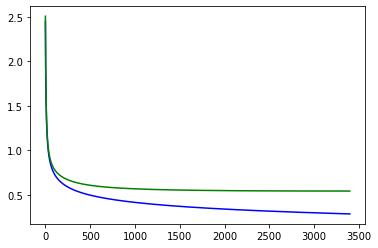

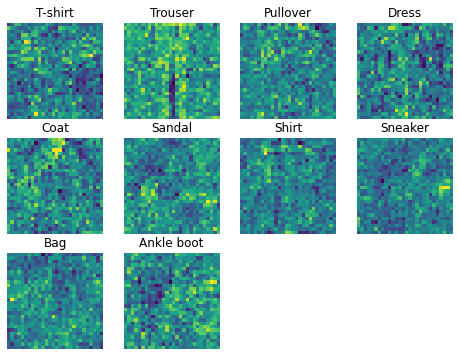

Epoch 3400: train loss: 0.28363 || val loss: 0.54099
Confusion matrix:
[[0.93 0.   0.02 0.04 0.   0.   0.02 0.   0.   0.  ]
 [0.02 0.95 0.   0.03 0.   0.   0.   0.   0.   0.  ]
 [0.02 0.   0.61 0.04 0.22 0.   0.11 0.   0.   0.  ]
 [0.07 0.05 0.   0.8  0.03 0.   0.05 0.   0.   0.  ]
 [0.   0.   0.09 0.05 0.74 0.   0.12 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.92 0.   0.08 0.   0.  ]
 [0.23 0.   0.09 0.02 0.19 0.   0.45 0.   0.02 0.  ]
 [0.   0.   0.   0.   0.   0.06 0.   0.84 0.   0.1 ]
 [0.   0.   0.   0.02 0.02 0.04 0.   0.   0.93 0.  ]
 [0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.98]]
Diagonal values:
[0.93 0.95 0.61 0.8  0.74 0.92 0.45 0.84 0.93 0.98]


In [ ]:
#@title Training { display-mode: "both" }
num_epoch = 10000 #@param {type:"integer"}
learning_rate = 0.01 #@param {type:"number"}
momentum_rate = 0.9 #@param {type:"number"}
epochs_to_draw = 10 #@param {type:"integer"}
update_weight_method = "normal" #@param ["normal", "momentum"]

np.random.seed(2020)

# Load data from file
# Make sure that fashion-mnist/*.gz files is in data/
train_x, train_y, val_x, val_y, test_x, test_y = get_mnist_data()
num_train = train_x.shape[0]
num_val = val_x.shape[0]
num_test = test_x.shape[0]  

# Convert label lists to one-hot (one-of-k) encoding
train_y = create_one_hot(train_y)
val_y = create_one_hot(val_y)
test_y = create_one_hot(test_y)

# Normalize our data
train_x, val_x, test_x = normalize(train_x, val_x, test_x)

# Pad 1 as the last feature of train_x and test_x
train_x = add_one(train_x) 
val_x = add_one(val_x)
test_x = add_one(test_x)

# Create classifier
num_feature = train_x.shape[1]
dec_classifier = SoftmaxClassifier((num_feature, 10))
momentum = np.zeros_like(dec_classifier.w)

# Define hyper-parameters and train-related parameters
all_train_loss = []
all_val_loss = []
plt.ion()

for e in range(num_epoch):    
    train_y_hat = dec_classifier.feed_forward(train_x)
    val_y_hat = dec_classifier.feed_forward(val_x)

    train_loss = dec_classifier.compute_loss(train_y, train_y_hat)
    val_loss = dec_classifier.compute_loss(val_y, val_y_hat)

    grad = dec_classifier.get_grad(train_x, train_y, train_y_hat)

    # dec_classifier.numerical_check(train_x, train_y, grad)
    # Updating weight: choose either normal GD or GD with momentum
    if update_weight_method == "normal":
        dec_classifier.update_weight(grad, learning_rate)
    else:
        dec_classifier.update_weight_momentum(grad, learning_rate, momentum, momentum_rate)

    all_train_loss.append(train_loss) 
    all_val_loss.append(val_loss)
    
    if is_stop_training(all_val_loss):
        break

    if (e % epochs_to_draw == epochs_to_draw-1):
        from IPython.display import clear_output
        clear_output(wait=True)
        plot_softmax_loss(all_train_loss, all_val_loss)
        draw_weight(dec_classifier.w)
        plt.show()
        plt.pause(0.1) 
        print("Epoch %d: train loss: %.5f || val loss: %.5f" % (e+1, train_loss, val_loss))

y_hat = dec_classifier.feed_forward(test_x)
np.set_printoptions(precision=2)
confusion_mat = softmax_test(y_hat, test_y)
print('Confusion matrix:')
print(confusion_mat)
print('Diagonal values:')
print(confusion_mat.flatten()[0::11])

## Class SoftmaxRegressionTF bằng Tensorflow

Tại đây, các bạn cần định nghĩa mô hình SoftmaxRegressionTF.

In [ ]:
# GRADED FUNCTION
class SoftmaxRegressionTF(tf.keras.Model): 
    def __init__(self, num_class):
        super(SoftmaxRegressionTF, self).__init__()
        # TODO 8: init all weights 
        ### START CODE HERE ###
       # self.w = tf.Variable(num_class , dtype=tf.float32)
       # kernel_initializer = tf.keras.initializers.RandomNormal(0, np.sqrt(2./np.sum(num_class)), seed=2020)
        #self.w = tf.Variable(kernel_initializer, name = "w" , dtype=tf.float32)
        kernel_initializer=tf.keras.initializers.RandomNormal(seed=2020)
        w_shape = (kernel_initializer,num_class)
        self.w = tf.Variable(np.random.normal(0, np.sqrt(2./np.sum(w_shape)), w_shape) , name = "w" , dtype=tf.float32)
        #self.w = tf.Variable(tf.keras.initializers.RandomNormal(0, np.sqrt(2./np.sum(values)), values) , name = "w" , dtype=tf.float32)
        ### END CODE HERE ###

    def call(self, inputs, training=None, mask=None):
        # TODO 8: implement your feedforward 
        ### START CODE HERE ###
        output = tf.matmul(self.inputs, self.w)
        output_max = tf.reduce_max(output, 1, True)
        output -= output_max
        exp_output = tf.exp(output)
        output = exp_outputd / tf.reduce_sum(exp_output, 1, True)
        ### END CODE HERE ###
        try:
          output = tf.nn.softmax(output)
        except: # if softmax op does not exist on the gpu
          with tf.device('/cpu:0'):
              output = tf.nn.softmax(output) 

        return output

In [ ]:
### SANITY CHECK
logistic_regressor = SoftmaxRegressionTF(10)
dummy_x = tf.zeros((1, 13))
assert logistic_regressor(dummy_x).numpy().sum() == 1, "Wrong"

### TODO 8: init (10) + call (10)
Các bạn cần khởi tạo tất cả các trọng số ở hàm `init` và `call` của lớp `SoftmaxRegressionTF`. Để tiện cho việc chấm bài, các bạn vui lòng set `kernel_initializer=tf.keras.initializers.RandomNormal(seed=2020)` khi init weights. Nếu bạn không cài đặt `kernel_initializer` như yêu cầu, bạn sẽ bị mất điểm cho TODO 8 này.

## Huấn luyện với tensorflow

In [ ]:
#@title Training { display-mode: "both" }
num_epoch = 100 #@param {type:"integer"}
learning_rate = 0.001 #@param {type:"number"}
batch_size = 32
num_classes = 10

tf.random.set_seed(2020)

# Load data from file
# Make sure that fashion-mnist/*.gz files is in data/
train_x, train_y, val_x, val_y, test_x, test_y = get_mnist_data()
num_train = train_x.shape[0]
num_val = val_x.shape[0]
num_test = test_x.shape[0]  


# Convert label lists to one-hot (one-of-k) encoding
train_y = create_one_hot(train_y)
val_y = create_one_hot(val_y)
test_y = create_one_hot(test_y)

# Normalize our data
train_x, val_x, test_x = normalize(train_x, val_x, test_x)

device = '/cpu:0' if len(tf.config.experimental.list_physical_devices('GPU')) == 0 else '/gpu:0'

with tf.device(device):
    # build model and optimizer
    model = SoftmaxRegressionTF(num_classes)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    

    # train
    model.fit(train_x, train_y, batch_size=batch_size, epochs=num_epoch,
              validation_data=(val_x, val_y), verbose=2)

    # evaluate on test set
    scores = model.evaluate(test_x, test_y, 32, verbose=2)
    
    y_hat = model.predict(test_x)


    confusion_mat = softmax_test(y_hat, test_y)
    print('Confusion matrix:')
    print(confusion_mat)
    print('Diagonal values:')
    print(confusion_mat.flatten()[0::11])

Reading fashion MNIST data...
Epoch 1/100
79/79 - 0s - loss: 0.1712 - accuracy: 0.6228 - val_loss: 0.1290 - val_accuracy: 0.7200
Epoch 2/100
79/79 - 0s - loss: 0.1085 - accuracy: 0.7824 - val_loss: 0.1137 - val_accuracy: 0.7600
Epoch 3/100
79/79 - 0s - loss: 0.0945 - accuracy: 0.8168 - val_loss: 0.1104 - val_accuracy: 0.7580
Epoch 4/100
79/79 - 0s - loss: 0.0861 - accuracy: 0.8364 - val_loss: 0.1003 - val_accuracy: 0.7940
Epoch 5/100
79/79 - 0s - loss: 0.0810 - accuracy: 0.8444 - val_loss: 0.0975 - val_accuracy: 0.7920
Epoch 6/100
79/79 - 0s - loss: 0.0776 - accuracy: 0.8508 - val_loss: 0.1031 - val_accuracy: 0.7860
Epoch 7/100
79/79 - 0s - loss: 0.0730 - accuracy: 0.8600 - val_loss: 0.0963 - val_accuracy: 0.8040
Epoch 8/100
79/79 - 0s - loss: 0.0697 - accuracy: 0.8708 - val_loss: 0.0988 - val_accuracy: 0.8100
Epoch 9/100
79/79 - 0s - loss: 0.0674 - accuracy: 0.8648 - val_loss: 0.1024 - val_accuracy: 0.7880
Epoch 10/100
79/79 - 0s - loss: 0.0642 - accuracy: 0.8780 - val_loss: 0.1008 - 